**This notebook demonstrates how to train and evaluate the classifier**

To run:
1. Create a virtual environment
2. `pip install git+https://github.com/AllenInstitute/DeepCell.git`

In [1]:
import sys

sys.path.append('../../src/')

In [2]:
from deepcell.cli.modules.create_dataset import CreateDataset
from deepcell.cli.modules.train import TrainRunner
from deepcell.cli.modules.inference import InferenceModule
from deepcell.datasets.model_input import ModelInput
from deepcell.data_splitter import DataSplitter
from deepcell.plotting import plot_confusion_matrix, plot_pr_curve
from pathlib import Path
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import json
import torch
import numpy as np
import random

In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 10]

In [ ]:
OUTPUT_DIR = Path(input('Path to output files'))
SEED = 1234

In [5]:
def set_seed(seed=SEED):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed()

In [6]:
set_seed()

# Train/test split

Assign each observation a label and split into a train and test set

In [5]:
def create_dataset(test_size: float = 0.3, vote_tallying_strategy: str = 'majority') -> None:
    """
    1. Pulls the raw labels, 
    2. tallies votes for each ROI to get a single label
    3. Creates train/test split using depth bin sampling strategy
    4. Outputs json files needed for training/inference
    
    :param test_size: The fraction to reserve for the test set
    :param vote_tallying_strategy: Vote tallying strategy for deciding on a label for each ROI
    """    
    args = {
        'labels_path': input('Path to raw labels'),
        'artifact_dir': input('Path to directory containing max, correlation, and mask for each ROI in the dataset'),
        'experiment_metadata': input('Path to json file containing metadata on each experiment (including depth)'),
        'seed': SEED,
        'test_size': test_size,
        'output_dir': str(OUTPUT_DIR)
    }
    CreateDataset(args=[], input_data=args).run()

In [ ]:
create_dataset()

The above should have created 2 files in output_dir: 
1. train_rois.json
2. test_rois.json

This represents the train/test split. Each file contains several important variables for each ROI including paths to artifacts input to the classifier (mask, correlation projection, max projection), as well as the label chosen based on the vote tallying strategy.

In [7]:
with open(OUTPUT_DIR / 'train_rois.json') as f:
    train = [ModelInput(**x) for x in json.load(f)]
with open(OUTPUT_DIR / 'test_rois.json') as f:
    test = [ModelInput(**x) for x in json.load(f)]

In [8]:
print('Train size', len(train))
print('Test size', len(test))

Train size 17458
Test size 7101


# Train

Use k-fold cross validation to to train k models

In [9]:
K_FOLDS = 5

In [10]:
def create_train_val_splits(train: List[ModelInput], k_folds: int = K_FOLDS) -> None:
    """
    Splits the data into train/val test splits for k fold cross validation
    
    :param k_folds: the number of splits
    :param train: the training set
    """
    
    for k, (train_idx, test_idx) in enumerate(
            DataSplitter.get_cross_val_split_idxs(
                model_inputs=train, seed=SEED,
                n_splits=k_folds)):
        with open(OUTPUT_DIR / f'train_{k}.json', 'w') as f:
            f.write(json.dumps([train[i].to_dict() for i in train_idx], indent=2))
        with open(OUTPUT_DIR / f'val_{k}.json', 'w') as f:
            f.write(json.dumps([train[i].to_dict() for i in test_idx], indent=2))
            

In [11]:
create_train_val_splits(train=train)

We should now have several files with the format

- train_k.json
- val_k.json

for each fold

In [12]:
def train():
    for k in range(K_FOLDS):
        args = {
            'train_model_inputs_path': str(OUTPUT_DIR / f'train_{k}.json'),
            'validation_model_inputs_path': str(OUTPUT_DIR / f'val_{k}.json'),
            'fold': k,
            'save_path': str(OUTPUT_DIR / 'model'),
            'log_path': str(OUTPUT_DIR / 'train.log'),
            'model_params': {
                'model_architecture': 'vgg11_bn',
                'truncate_to_layer': 22,
                'freeze_to_layer': 8,
                'use_pretrained_model': True
            }
        }
        print(f'Training fold {k}')
        
        TrainRunner(args=[], input_data=args).run()

In [ ]:
train()

# Performance

In [9]:
def get_predictions(mode: str):
    """
    Computes predictions on validation/test set using trained models
    Outputs a file "cv_preds.csv" in case of mode=="CV" or "test_preds.csv" in case of mode=="test" 
        in `OUTPUT_DIR` containing predictions on the validation/test set
    
    :param mode: Either "CV" for validation predictions or "test" for test set predictions
    """
    if mode == 'CV':
        model_inputs_paths = [str(OUTPUT_DIR / f'val_{k}.json') for k in range(K_FOLDS)]
    else:
        model_inputs_paths = [str(OUTPUT_DIR / 'test_rois.json')]
    args = {
        "model_params": {
            "use_pretrained_model": True,
            "model_architecture": "vgg11_bn",
            "truncate_to_layer": 22
        },
        "model_inputs_paths": model_inputs_paths,
        "model_load_path": str(OUTPUT_DIR / 'model'),
        "save_path": str(OUTPUT_DIR),
        "mode": mode
    }
    InferenceModule(args=[], input_data=args).run()

In [ ]:
get_predictions(mode='CV')

In [ ]:
get_predictions(mode='test')

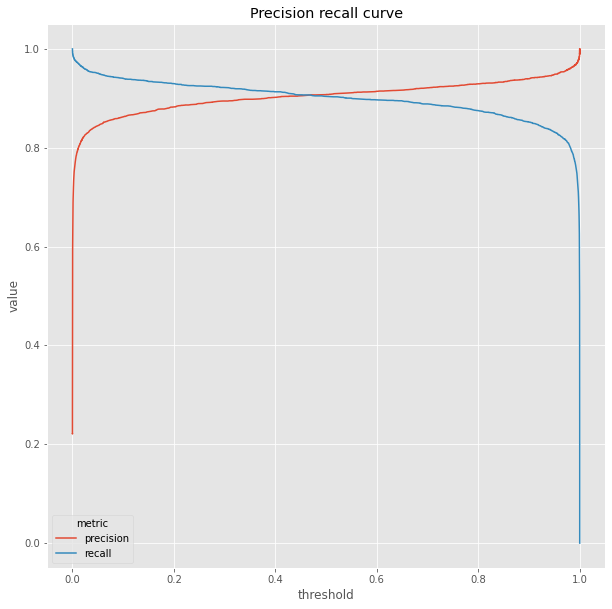

In [26]:
plot_pr_curve(scores=pd.read_csv(OUTPUT_DIR / 'cv_preds.csv'))

In [7]:
def plot_test_set_performance():
    preds = pd.read_csv(OUTPUT_DIR / 'test_preds.csv')
    preds['y_pred'] = preds['y_pred'].apply(lambda x: 'cell' if x else 'not cell')
    
    plot_confusion_matrix(
        classifier_scores=preds,
        label_col='y_true', pred_col='y_pred')

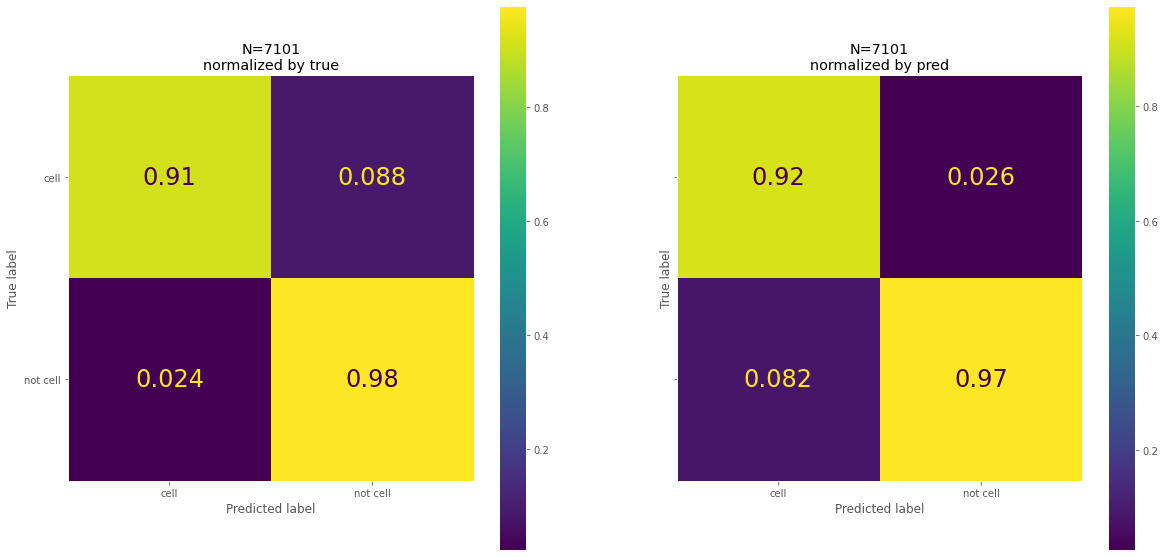

In [8]:
plot_test_set_performance()